In [1]:
import torch
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pdb
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import sys

sys.path.insert(0, './src')

from data import Dataset
from kernels import HMC_our
from models import Gen_network, Inf_network
from target import NN_bernoulli
from utils import plot_digit_samples, get_samples
from args import get_args

In [2]:
torchType = torch.float32

In [3]:
def set_seeds(rand_seed):
#     torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(rand_seed)
    np.random.seed(rand_seed)
    random.seed(rand_seed)

seed = 1 # 1337 #
set_seeds(seed)

In [4]:
args = get_args()

In [5]:
encoder = Inf_network(kwargs=args).to(args.device)
target = NN_bernoulli(kwargs=args, model=Gen_network(args.z_dim, args), device=args.device).to(args.device)

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
for p in transitions.parameters():
    p.requires_grad_(False)
params = [encoder.parameters(), target.parameters(), transitions.parameters()]
optimizer = torch.optim.Adam(params=itertools.chain(*params), lr=1e-3)

In [6]:
dataset = Dataset(args, device=args.device)

In [7]:
random_code = args.std_normal.sample((64, args.z_dim))

  0%|          | 0/400 [00:00<?, ?it/s]

On batch number 1/100 and on k = 1 we have for  0: 0.5660000268835574 and for +1: 0.43400002061389387
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 0.49400002346374094 and for +1: 0.5060000240337104
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.49800002365373075 and for +1: 0.5020000238437206
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.5040000239387155 and for +1: 0.49600002355873585
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.49200002336874604 and for +1: 0.5080000241287053
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 2 	 Current ELBO: -1.1774005037220705e+20
Saved samples to ./pics/mnist_epoch_1_K_5_N_1_amortize_True.png


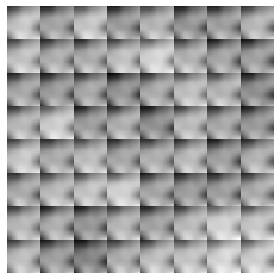

  0%|          | 2/400 [01:41<5:36:02, 50.66s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9920000471174717 and for +1: 0.00800000037997961
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 3 	 Current ELBO: -7.292611885556587e+21
Saved samples to ./pics/mnist_epoch_2_K_5_N_1_amortize_True.png


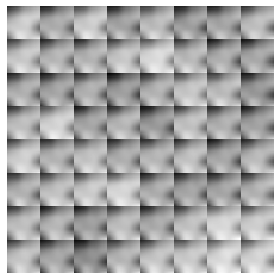

  1%|          | 3/400 [02:31<5:35:20, 50.68s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 4 	 Current ELBO: -1.2672864764942468e+22
Saved samples to ./pics/mnist_epoch_3_K_5_N_1_amortize_True.png


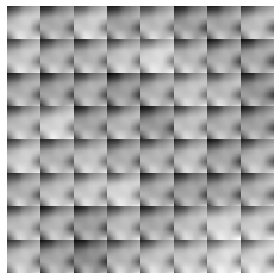

  1%|          | 4/400 [03:22<5:34:37, 50.70s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 5 	 Current ELBO: -1.6469058103144023e+22
Saved samples to ./pics/mnist_epoch_4_K_5_N_1_amortize_True.png


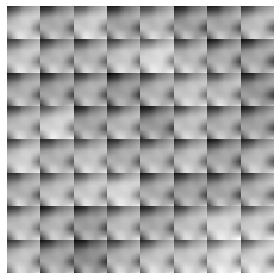

  1%|▏         | 5/400 [04:13<5:34:19, 50.78s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 6 	 Current ELBO: -1.9245896568587378e+22
Saved samples to ./pics/mnist_epoch_5_K_5_N_1_amortize_True.png


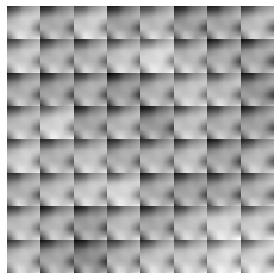

  2%|▏         | 6/400 [05:04<5:33:51, 50.84s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.986000046832487 and for +1: 0.014000000664964318
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.010000000474974513 and for +1: 0.9900000470224768
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 7 	 Current ELBO: -2.2320251832614083e+22
Saved samples to ./pics/mnist_epoch_6_K_5_N_1_amortize_True.png


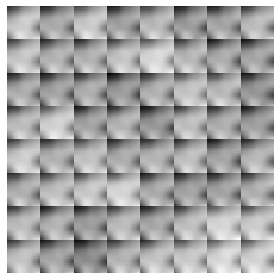

  2%|▏         | 7/400 [05:55<5:33:16, 50.88s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9920000471174717 and for +1: 0.00800000037997961
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.010000000474974513 and for +1: 0.9900000470224768
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 8 	 Current ELBO: -2.31251126400196e+22
Saved samples to ./pics/mnist_epoch_7_K_5_N_1_amortize_True.png


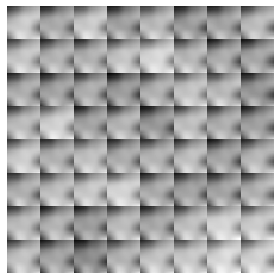

  2%|▏         | 8/400 [06:46<5:32:36, 50.91s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9980000474024564 and for +1: 0.0020000000949949026
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 9 	 Current ELBO: -2.415160008868765e+22
Saved samples to ./pics/mnist_epoch_8_K_5_N_1_amortize_True.png


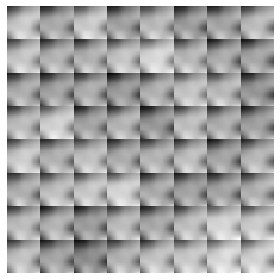

  2%|▏         | 9/400 [07:37<5:31:53, 50.93s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.006000000284984708 and for +1: 0.9940000472124666
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 10 	 Current ELBO: -2.483164138062078e+22
Saved samples to ./pics/mnist_epoch_9_K_5_N_1_amortize_True.png


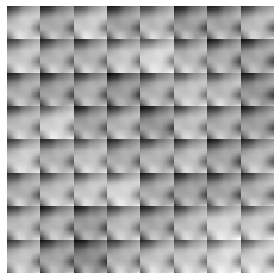

  2%|▎         | 10/400 [08:28<5:31:07, 50.94s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 11 	 Current ELBO: -2.6860992646111503e+22
Saved samples to ./pics/mnist_epoch_10_K_5_N_1_amortize_True.png


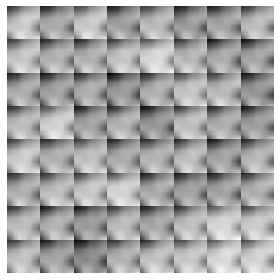

  3%|▎         | 11/400 [09:19<5:30:23, 50.96s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9920000471174717 and for +1: 0.00800000037997961
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 12 	 Current ELBO: -2.669829785777293e+22
Saved samples to ./pics/mnist_epoch_11_K_5_N_1_amortize_True.png


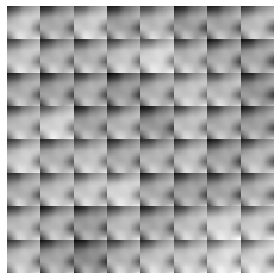

  3%|▎         | 12/400 [10:10<5:29:35, 50.97s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9920000471174717 and for +1: 0.00800000037997961
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.012000000569969416 and for +1: 0.9880000469274819
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 13 	 Current ELBO: -2.798341127044217e+22
Saved samples to ./pics/mnist_epoch_12_K_5_N_1_amortize_True.png


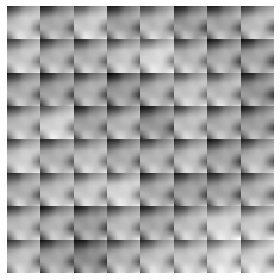

  3%|▎         | 13/400 [11:01<5:28:44, 50.97s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 14 	 Current ELBO: -2.8680764399342913e+22
Saved samples to ./pics/mnist_epoch_13_K_5_N_1_amortize_True.png


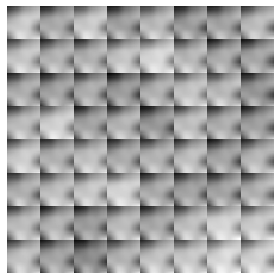

  4%|▎         | 14/400 [11:52<5:27:53, 50.97s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.004000000189989805 and for +1: 0.9960000473074615
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 15 	 Current ELBO: -3.0093615660043076e+22
Saved samples to ./pics/mnist_epoch_14_K_5_N_1_amortize_True.png


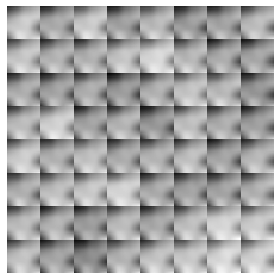

  4%|▍         | 15/400 [12:43<5:27:03, 50.97s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.006000000284984708 and for +1: 0.9940000472124666
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 16 	 Current ELBO: -2.9430996543268427e+22
Saved samples to ./pics/mnist_epoch_15_K_5_N_1_amortize_True.png


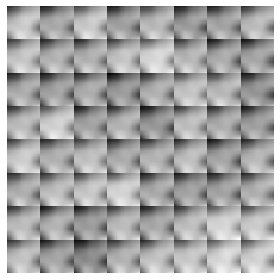

  4%|▍         | 16/400 [13:34<5:26:11, 50.97s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9900000470224768 and for +1: 0.010000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 17 	 Current ELBO: -3.025415547595995e+22
Saved samples to ./pics/mnist_epoch_16_K_5_N_1_amortize_True.png


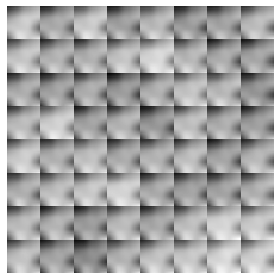

  4%|▍         | 17/400 [14:25<5:25:20, 50.97s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.01600000075995922 and for +1: 0.9840000467374921
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 18 	 Current ELBO: -3.0506978551841277e+22
Saved samples to ./pics/mnist_epoch_17_K_5_N_1_amortize_True.png


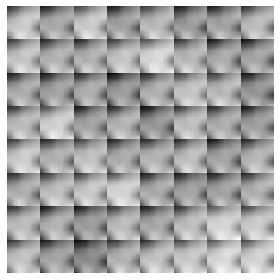

  4%|▍         | 18/400 [15:16<5:24:30, 50.97s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.006000000284984708 and for +1: 0.9940000472124666
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 19 	 Current ELBO: -3.0865854643547736e+22
Saved samples to ./pics/mnist_epoch_18_K_5_N_1_amortize_True.png


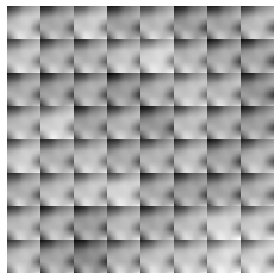

  5%|▍         | 19/400 [16:07<5:23:39, 50.97s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.006000000284984708 and for +1: 0.9940000472124666
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 20 	 Current ELBO: -3.0795965532730387e+22
Saved samples to ./pics/mnist_epoch_19_K_5_N_1_amortize_True.png


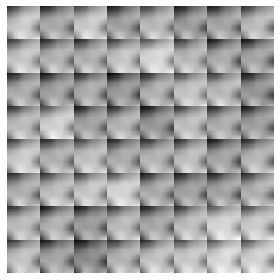

  5%|▌         | 20/400 [16:58<5:22:49, 50.97s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.010000000474974513 and for +1: 0.9900000470224768
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 21 	 Current ELBO: -3.142488871709305e+22
Saved samples to ./pics/mnist_epoch_20_K_5_N_1_amortize_True.png


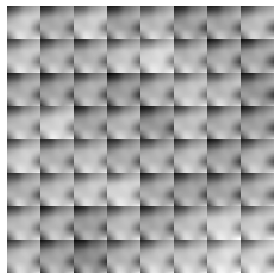

  5%|▌         | 21/400 [17:49<5:21:57, 50.97s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9980000474024564 and for +1: 0.0020000000949949026
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.006000000284984708 and for +1: 0.9940000472124666
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 22 	 Current ELBO: -3.2408718070090643e+22
Saved samples to ./pics/mnist_epoch_21_K_5_N_1_amortize_True.png


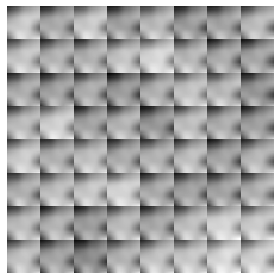

  6%|▌         | 22/400 [18:40<5:21:10, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 23 	 Current ELBO: -3.210313307277486e+22
Saved samples to ./pics/mnist_epoch_22_K_5_N_1_amortize_True.png


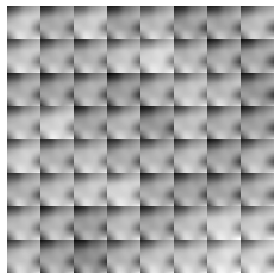

  6%|▌         | 23/400 [19:31<5:20:20, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 24 	 Current ELBO: -3.230595943739293e+22
Saved samples to ./pics/mnist_epoch_23_K_5_N_1_amortize_True.png


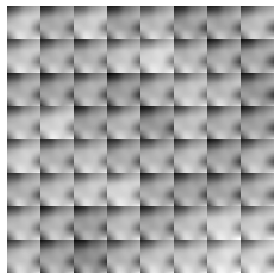

  6%|▌         | 24/400 [20:22<5:19:29, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9980000474024564 and for +1: 0.0020000000949949026
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.004000000189989805 and for +1: 0.9960000473074615
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 25 	 Current ELBO: -3.296398488254766e+22
Saved samples to ./pics/mnist_epoch_24_K_5_N_1_amortize_True.png


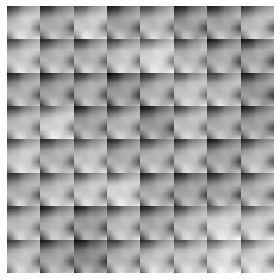

  6%|▋         | 25/400 [21:13<5:18:42, 50.99s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9980000474024564 and for +1: 0.0020000000949949026
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 26 	 Current ELBO: -3.2380674155211007e+22
Saved samples to ./pics/mnist_epoch_25_K_5_N_1_amortize_True.png


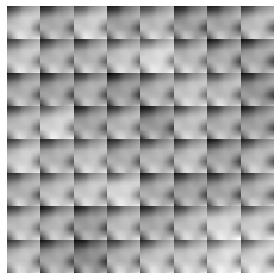

  6%|▋         | 26/400 [22:04<5:17:49, 50.99s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9920000471174717 and for +1: 0.00800000037997961
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.010000000474974513 and for +1: 0.9900000470224768
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 27 	 Current ELBO: -3.25833721672397e+22
Saved samples to ./pics/mnist_epoch_26_K_5_N_1_amortize_True.png


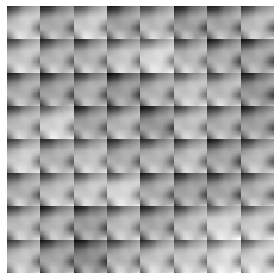

  7%|▋         | 27/400 [22:55<5:16:57, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 28 	 Current ELBO: -3.2506025095439424e+22
Saved samples to ./pics/mnist_epoch_27_K_5_N_1_amortize_True.png


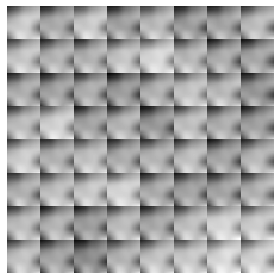

  7%|▋         | 28/400 [23:46<5:16:04, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9880000469274819 and for +1: 0.012000000569969416
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.018000000854954123 and for +1: 0.9820000466424972
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 29 	 Current ELBO: -3.338099343824422e+22
Saved samples to ./pics/mnist_epoch_28_K_5_N_1_amortize_True.png


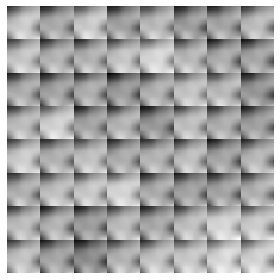

  7%|▋         | 29/400 [24:37<5:15:13, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9980000474024564 and for +1: 0.0020000000949949026
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 30 	 Current ELBO: -3.419046367986835e+22
Saved samples to ./pics/mnist_epoch_29_K_5_N_1_amortize_True.png


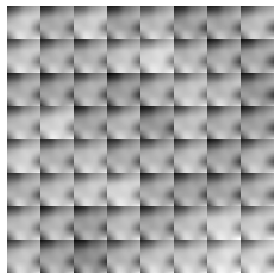

  8%|▊         | 30/400 [25:28<5:14:21, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.006000000284984708 and for +1: 0.9940000472124666
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 31 	 Current ELBO: -3.433107957103374e+22
Saved samples to ./pics/mnist_epoch_30_K_5_N_1_amortize_True.png


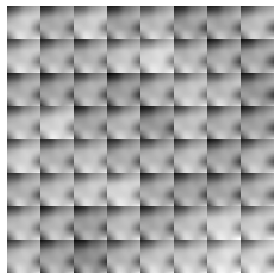

  8%|▊         | 31/400 [26:19<5:13:30, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.012000000569969416 and for +1: 0.9880000469274819
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 32 	 Current ELBO: -3.376868130856678e+22
Saved samples to ./pics/mnist_epoch_31_K_5_N_1_amortize_True.png


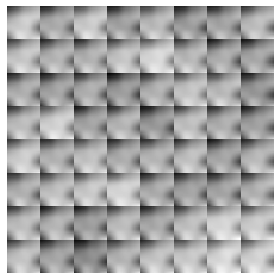

  8%|▊         | 32/400 [27:10<5:12:39, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9880000469274819 and for +1: 0.012000000569969416
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.014000000664964318 and for +1: 0.986000046832487
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 33 	 Current ELBO: -3.305367181732693e+22
Saved samples to ./pics/mnist_epoch_32_K_5_N_1_amortize_True.png


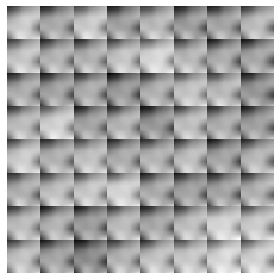

  8%|▊         | 33/400 [28:01<5:11:48, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.004000000189989805 and for +1: 0.9960000473074615
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 34 	 Current ELBO: -3.311587328358036e+22
Saved samples to ./pics/mnist_epoch_33_K_5_N_1_amortize_True.png


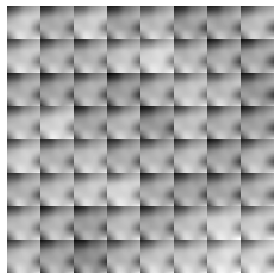

  8%|▊         | 34/400 [28:52<5:10:57, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.010000000474974513 and for +1: 0.9900000470224768
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 35 	 Current ELBO: -3.395191025940635e+22
Saved samples to ./pics/mnist_epoch_34_K_5_N_1_amortize_True.png


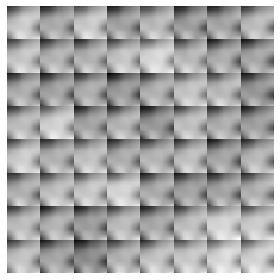

  9%|▉         | 35/400 [29:43<5:10:06, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.006000000284984708 and for +1: 0.9940000472124666
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 36 	 Current ELBO: -3.696128083260991e+22
Saved samples to ./pics/mnist_epoch_35_K_5_N_1_amortize_True.png


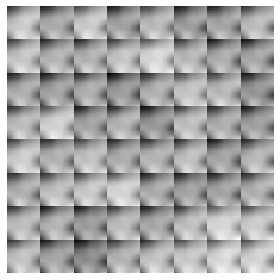

  9%|▉         | 36/400 [30:34<5:09:15, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9900000470224768 and for +1: 0.010000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.006000000284984708 and for +1: 0.9940000472124666
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 37 	 Current ELBO: -3.550397228818816e+22
Saved samples to ./pics/mnist_epoch_36_K_5_N_1_amortize_True.png


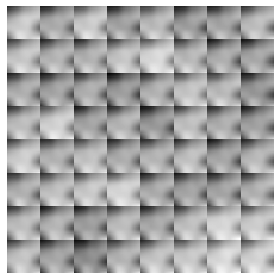

  9%|▉         | 37/400 [31:25<5:08:23, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.010000000474974513 and for +1: 0.9900000470224768
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 38 	 Current ELBO: -3.510736278700378e+22
Saved samples to ./pics/mnist_epoch_37_K_5_N_1_amortize_True.png


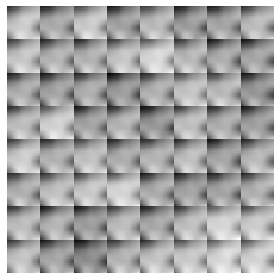

 10%|▉         | 38/400 [32:15<5:07:32, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9920000471174717 and for +1: 0.00800000037997961
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 39 	 Current ELBO: -3.62965450240104e+22
Saved samples to ./pics/mnist_epoch_38_K_5_N_1_amortize_True.png


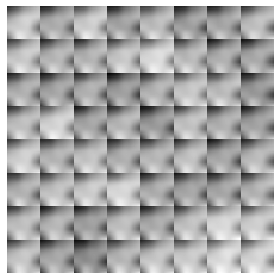

 10%|▉         | 39/400 [33:06<5:06:45, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 40 	 Current ELBO: -3.586606169822875e+22
Saved samples to ./pics/mnist_epoch_39_K_5_N_1_amortize_True.png


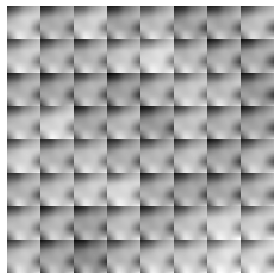

 10%|█         | 40/400 [33:57<5:05:53, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9900000470224768 and for +1: 0.010000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.012000000569969416 and for +1: 0.9880000469274819
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 41 	 Current ELBO: -3.593122202943736e+22
Saved samples to ./pics/mnist_epoch_40_K_5_N_1_amortize_True.png


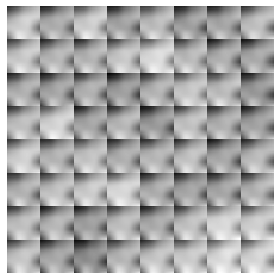

 10%|█         | 41/400 [34:48<5:05:00, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9920000471174717 and for +1: 0.00800000037997961
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.010000000474974513 and for +1: 0.9900000470224768
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 42 	 Current ELBO: -3.789683610120172e+22
Saved samples to ./pics/mnist_epoch_41_K_5_N_1_amortize_True.png


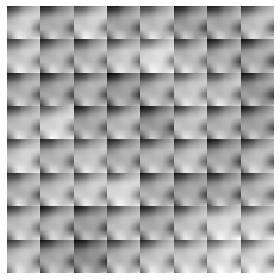

 10%|█         | 42/400 [35:39<5:04:09, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9920000471174717 and for +1: 0.00800000037997961
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.004000000189989805 and for +1: 0.9960000473074615
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 43 	 Current ELBO: -3.508581981818625e+22
Saved samples to ./pics/mnist_epoch_42_K_5_N_1_amortize_True.png


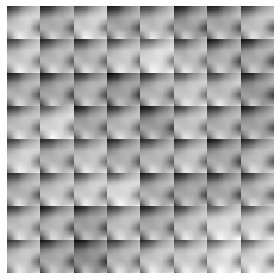

 11%|█         | 43/400 [36:30<5:03:18, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.004000000189989805 and for +1: 0.9960000473074615
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 44 	 Current ELBO: -3.5522024967294476e+22
Saved samples to ./pics/mnist_epoch_43_K_5_N_1_amortize_True.png


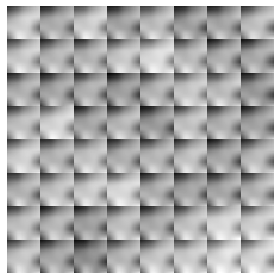

 11%|█         | 44/400 [37:21<5:02:27, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9920000471174717 and for +1: 0.00800000037997961
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.004000000189989805 and for +1: 0.9960000473074615
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 45 	 Current ELBO: -3.630647996478838e+22
Saved samples to ./pics/mnist_epoch_44_K_5_N_1_amortize_True.png


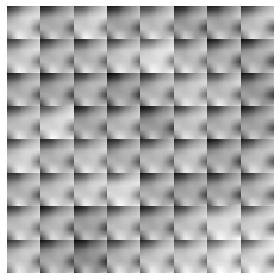

 11%|█▏        | 45/400 [38:12<5:01:36, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9980000474024564 and for +1: 0.0020000000949949026
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.006000000284984708 and for +1: 0.9940000472124666
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 46 	 Current ELBO: -3.798701618014019e+22
Saved samples to ./pics/mnist_epoch_45_K_5_N_1_amortize_True.png


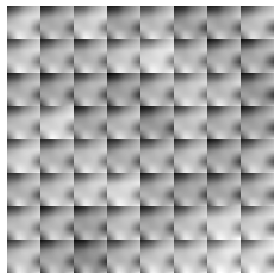

 12%|█▏        | 46/400 [39:03<5:00:46, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.012000000569969416 and for +1: 0.9880000469274819
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 47 	 Current ELBO: -3.6127673548782887e+22
Saved samples to ./pics/mnist_epoch_46_K_5_N_1_amortize_True.png


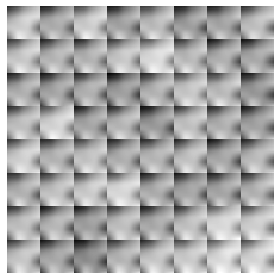

 12%|█▏        | 47/400 [39:54<4:59:55, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9960000473074615 and for +1: 0.004000000189989805
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
Current epoch: 48 	 Current ELBO: -3.6576205050071224e+22
Saved samples to ./pics/mnist_epoch_47_K_5_N_1_amortize_True.png


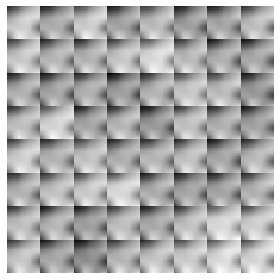

 12%|█▏        | 48/400 [40:45<4:59:03, 50.98s/it]

On batch number 1/100 and on k = 1 we have for  0: 0.0 and for +1: 1.0000000474974513
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 2 we have for  0: 1.0000000474974513 and for +1: 0.0
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 3 we have for  0: 0.9940000472124666 and for +1: 0.006000000284984708
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 4 we have for  0: 0.0020000000949949026 and for +1: 0.9980000474024564
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448
On batch number 1/100 and on k = 5 we have for  0: 0.00800000037997961 and for +1: 0.9920000471174717
Stepsize 0.049999998305995476
Autoregression coeff 0.7500000596046448


KeyboardInterrupt: 

In [8]:
print_info_ = 1

torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)

def compute_loss(z, p, u, p_old, x, current_log_alphas, log_jac, sum_log_sigma):
    log_p = target.get_logdensity(z=z, x=x) + args.std_normal.log_prob(p).sum(1)
    log_r = -args.K * torch_log_2
    log_m = args.std_normal.log_prob(u).sum(1) - sum_log_sigma + args.std_normal.log_prob(p_old).sum(1) - log_jac + current_log_alphas
    elbo_full = log_p + log_r - log_m
    current_grad = torch.mean(log_p + (current_log_alphas + args.std_normal.log_prob(u).sum(1) - sum_log_sigma) * (elbo_full.detach() - 1.))
    return elbo_full, current_grad
  
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataset.next_train_batch()): # cycle over batches
        cond_vectors = [args.std_normal.sample((args.z_dim, )) for _ in range(args.K)]
        optimizer.zero_grad()

        mu, sigma = encoder(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + sigma * u # reperametrization trick
        p_old = args.std_normal.sample(mu.shape)

        sum_log_sigma = torch.sum(torch.log(sigma), 1)
        
        sum_grad = 0.
        z = z.detach()
        p = p_old
        for k in range(args.K):
            # sample alpha - transition probabilities 
            if args.amortize:
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z.detach(), x=batch_train,
                                                    p_old=p.detach(), k=cond_vectors[k], target_distr=target)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z.detach(), x=batch_train,
                                                                    p_old=p.detach(), k=cond_vectors[k], target_distr=target) # sample a_i -- directions

            if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                        dataset.train.shape[0] // args['train_batch_size'],
                                                                           k + 1,
                                                    (directions==0.).to(float).mean(),
                                                                    (directions==1.).to(float).mean()))
                if args.amortize:
                    print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                    print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))

            elbo_full, current_grad = compute_loss(z=z, p=p, u=u, p_old=p_old,
                                        x=batch_train, current_log_alphas=current_log_alphas, log_jac=log_jac, sum_log_sigma=sum_log_sigma)
            sum_grad += current_grad

        (-sum_grad).backward()
        optimizer.step()
        optimizer.zero_grad()
        # Bias squared
    if ep % print_info_ == 0:
        print('Current epoch:', (ep + 1), '\t', 'Current ELBO:', elbo_full.detach().mean().item())
        plot_digit_samples(samples=get_samples(target.decoder, random_code), args=args, epoch=ep)